In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
# notebook level imports
import numpy as np                    # numpy arrays
import matplotlib.pyplot as plt       # image manipulation
from matplotlib.colors import to_hex  # hex representation of colors
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from dsutils import plot_elbow

# Image Compression: Color Quantization using k-Means

In computer graphics, **color quantization** is a process that reduces the number of distinct colors used in an image, usually with the intention that the new image should be as visually similar as possible to the original image.

An example image in 24-bit RGB color, <br>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Dithering_example_undithered.png">
</center>

The same image reduced to a palette of 16 colors ,<br>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/Dithering_example_undithered_16color_palette.png">
</center>

The palette is chosen using the k-means algorithm in RGB color space as shown below,
<br>
<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3d/Rosa_Gold_Glow_2_small_noblue_color_space.png" height="300" width="300">
</center>

(source: [Wikipedia](https://en.wikipedia.org/wiki/Color_quantization))

# A Worked Example

Perform a color quantization of an image of Yellowstone, **reducing the number of colors required to show the image from 16mil
unique colors to 8 colors**, while preserving the overall appearance quality as much as possible.

Based on the [quantization example from SKlearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py)

In [3]:
# number of colors to use for quantization
n_colors = 8

## Image Data

We load a JPEG image from our folder.  **Note**, the technique we present here will work with any JPEG image.

In [4]:
# load the image
img = plt.imread(home+"yellowstone.jpg")
img.shape

(446, 669, 3)

In [5]:
type(img)

numpy.ndarray

**Observation**: It is a 446x669 image with three integers describing the color at each pixel represented as a 3D array

What do values in the image array look like?

In [6]:
# take a look at the top-left pixel
img[0,0,]

array([70, 88, 64], dtype=uint8)

In [7]:
# We need to convert to float [0.0-1.0] for RGB representation in pyplot
img = img / 255
img[0,0,]

array([0.2745098 , 0.34509804, 0.25098039])

**Observation**:  The RGB color model supports 16mil colors ($256^3$)

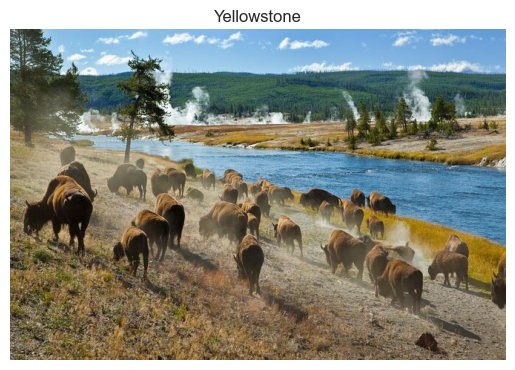

In [8]:
# show the image
plt.clf()
plt.axis('off')
plt.title('Yellowstone')
plt.imshow(img)
plt.show()

## Training Data

Turn the image into training data for our k-means algorithm.  We need to transform the 3D image structure into a 2D training dataset.
The training set is simply a list of all the pixels in 3D RGB color space.

In [9]:
# transform 3D image structure to a 2D numpy array for training the k-means model
# by listing all pixels as a continuous list of color vectors

w, h, d = img.shape
assert d == 3

# the array is now a list of color values: list of points/pixels in RGB space.
pixels = np.reshape(img, (w * h, 3))
pixels[:16,]  # show the first 16 pixels

array([[0.2745098 , 0.34509804, 0.25098039],
       [0.43529412, 0.50588235, 0.41960784],
       [0.38823529, 0.4627451 , 0.38823529],
       [0.19215686, 0.2745098 , 0.21568627],
       [0.37254902, 0.45098039, 0.41568627],
       [0.44705882, 0.52941176, 0.50980392],
       [0.54117647, 0.62745098, 0.61568627],
       [0.24313725, 0.32941176, 0.32156863],
       [0.18431373, 0.2627451 , 0.25882353],
       [0.29019608, 0.36470588, 0.35686275],
       [0.26666667, 0.32941176, 0.31764706],
       [0.17647059, 0.22745098, 0.2       ],
       [0.18823529, 0.23529412, 0.18823529],
       [0.31372549, 0.35686275, 0.29411765],
       [0.19607843, 0.22352941, 0.15294118],
       [0.25882353, 0.29411765, 0.21960784]])

In [10]:
assert len(pixels) == w*h
len(pixels)

298374

**Observation**: Our image has more than a quarter million pixels.  This is way too much data to train our k-means algorithm.  

We sample the pixel data to create our training data.

In [11]:
# create a 1% sample of the data
sample_size = len(pixels)//100 # ~ 3000 pixels
# shuffle the pixel data and then take the a sample of the appropriate size
pixels_sample = shuffle(pixels, random_state=0)[:sample_size]

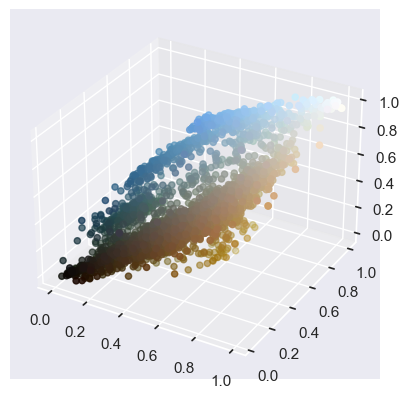

In [12]:
# plot training data in RGB space
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pixels_sample[:,0],
             pixels_sample[:,1],
             pixels_sample[:,2],
             c=pixels_sample);
plt.show()

## Model Building

The idea is now to use clustering with k centroids to find the k most significant colors in the RGB space.  We know that we want to use k=8 for our color quantization.

Let's take a look at the elbow method to see where our desired value falls in terms of useful clustering.

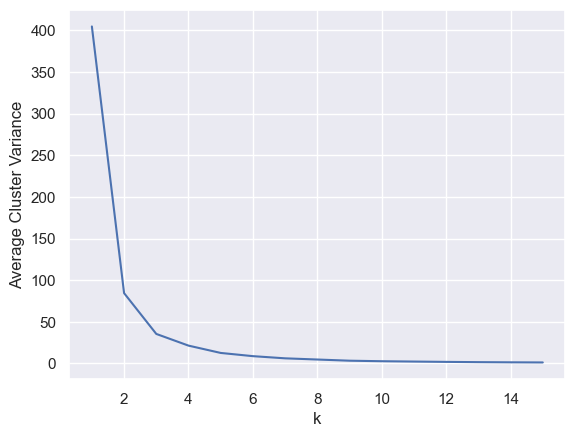

In [13]:
plot_elbow(pixels_sample, n=15)

**Observation**: It is interesting to note that k=8 appears at the upper end of the elbow.  So chosing k=8 is very reasonable. A lower k would mean that we might lose significant color differentiation and a higher k means that we are introducing colors which potentially do not add much more color differentiation to the image.

In [14]:
# train the model with n_colors
model = KMeans(n_clusters=n_colors,  # our 8 colors
               random_state=0)
model.fit(pixels_sample)

# the cluster centers now represent the new colors
centroid_pixels = model.cluster_centers_
centroid_pixels

array([[0.46053385, 0.38452841, 0.24599971],
       [0.53350065, 0.71619346, 0.86091503],
       [0.2685356 , 0.31999521, 0.27716944],
       [0.7017507 , 0.65552054, 0.55324463],
       [0.58542507, 0.51119134, 0.37998867],
       [0.32867317, 0.51048976, 0.62270289],
       [0.18706361, 0.16892635, 0.09967719],
       [0.79960172, 0.86712623, 0.88869485]])

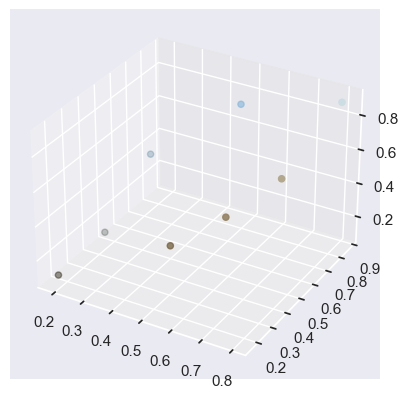

In [15]:
# plot the colors of the k-means model,
# that is plot the centroids of our model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(centroid_pixels[:,0],
             centroid_pixels[:,1],
             centroid_pixels[:,2],
             c=centroid_pixels)
plt.show()

**Observation**: Note that the centroids are placed at strategic points throughout the RGB space.

## Build Compressed Image

Now we map every pixel in our pixels array to our centroids.  In effect, we are replacing the pixel colors with the corresponding centroid colors.

In [16]:
# map each pixel in our pixels array to a centroid
pixel_centroid_labels = model.predict(pixels)

# show a random sample of the centroid labels
shuffle(pixel_centroid_labels)[:10]

array([0, 0, 0, 1, 1, 2, 1, 6, 2, 1], dtype=int32)

In [17]:
# create a new pixels array based on the color centroid
new_pixels = np.zeros((w*h,3)) # initialize the new pixes with zeros

# map the original pixels into new pixels based on the
# assigned centroid RGB value
for i in range(w*h):
    new_pixels[i] = centroid_pixels[pixel_centroid_labels[i]]

In [18]:
# reshape the new pixel array into a new image with the same dimensions as the original image.
new_img = np.reshape(new_pixels,(w,h,3))

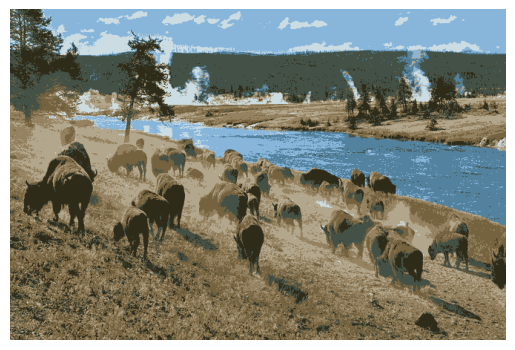

In [19]:
# show the new image
plt.clf()
plt.axis('off')
plt.imshow(new_img)
plt.show()

**Observation**: Nothing drastic happened to the image!

## Image Comparison

Not only do we show the original and the compressed image but we also save them to files so we can look at the effect that color quantization has on image file size.

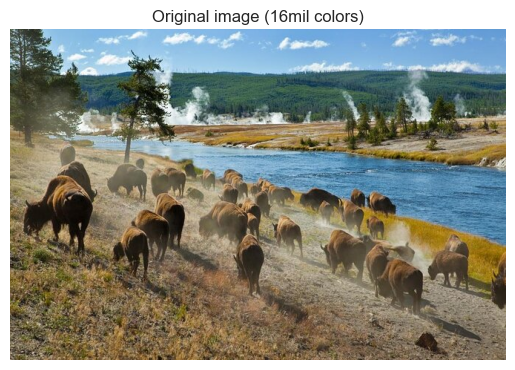

In [20]:
# original image
plt.clf()
plt.axis('off')
plt.title('Original image (16mil colors)')
plt.imshow(img)
plt.savefig("original.png")
plt.show()

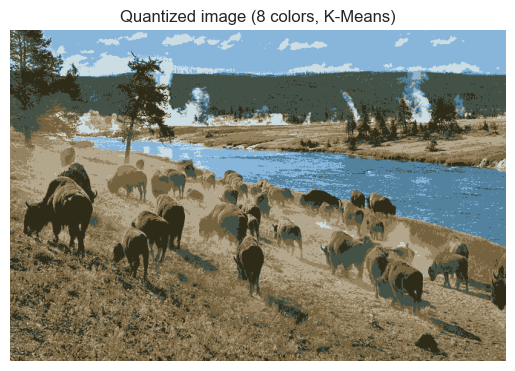

In [21]:
# quantized image
plt.clf()
plt.axis('off')
plt.title('Quantized image ({} colors, K-Means)'.format(n_colors))
plt.imshow(new_img)
plt.savefig("compressed.png")
plt.show()

Comparing the images sizes on disk.

In [22]:
if system == 'Windows':
   !dir original.png
   !dir compressed.png
else:
   !ls -s -k original.png
   !ls -s -k compressed.png

388 original.png
296 compressed.png
